In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import json

After processing prefill, cluster the keys into `k` clusters, keeping `local_k` number of local keys separate. This directly compares with regular eviction in terms of memory/bandwidth requirements.

In [10]:
original = pd.read_json("data/squad.jsonl", lines=True)

In [11]:
original

,dataset,shots,model_scale,sparsity,k,local_ratio,results,_duration
0,squad,1,1b,none,NaN,NaN,"[{'id': '5711607f2419e314009555cf', 'output': ...",1297.809070
1,squad,1,1b,eviction,64.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",2902.680239
2,squad,1,1b,eviction,128.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",2759.579782
3,squad,1,1b,eviction,256.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",2717.690772
4,squad,1,1b,eviction,512.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",2719.688717
5,squad,1,1b,eviction,1024.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",2873.645208
6,squad,1,1b,clustering,64.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",3404.175287
7,squad,1,1b,clustering,128.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",2729.317931
8,squad,1,1b,clustering,256.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",2491.036859
9,squad,1,1b,clustering,512.0,0.25,"[{'id': '5711607f2419e314009555cf', 'output': ...",2310.196185


**Note**: `clustering` with `k=1024` broke due to examples in the dataset that had fewer than 1024 keys, as `kmeans` initialisation expects the number of vector elements to be bigger than the number of clusters.

In [12]:
def load_sweep(path: str) -> pd.DataFrame:
    with open(path) as f:
        return pd.DataFrame.from_dict(
            dict(**line, **result)
            for line in filter(lambda d: "results" in d, map(json.loads, f))
            for result in line["results"]
        ).drop(columns=["results", "_duration"])


pd.concat([load_sweep(f) for f in Path("data").glob("*.jsonl")]).reset_index(
    drop=True
).drop(columns=["id", "output", "local_ratio", "prefill_length"]).groupby(
    ["dataset", "shots", "model_scale", "sparsity", "k"], dropna=False
).mean().reset_index().to_json(
    "summary.jsonl",
    orient="records",
    lines=True
)


In [13]:
df = pd.read_json("summary.jsonl", lines=True)

In [14]:
grouped = df.groupby("sparsity")

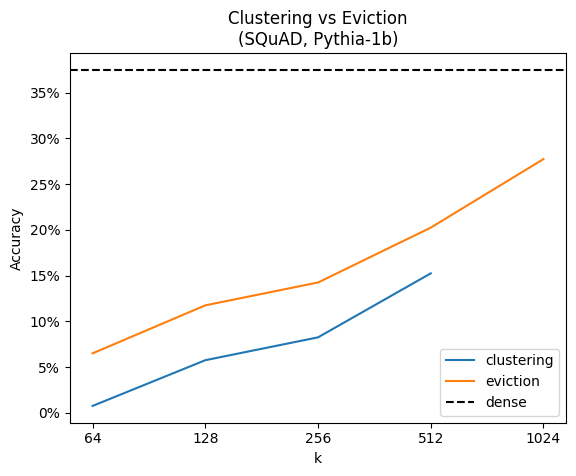

In [15]:
for sparsity, f in grouped:
    if sparsity == "none":
        plt.axhline(y = f["match"].item(), color = "black", linestyle="--", label="dense")
    else:
        plt.plot(f["k"], f["match"], label=sparsity)
plt.xscale("log", base=2)
ax = plt.gca()
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
plt.legend(loc="lower right")
plt.title("Clustering vs Eviction\n(SQuAD, Pythia-1b)")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()